---
author: brian-rose
---

# Multi-model feedback comparison

---

## Overview

The goal of this notebook is to explore inter-model differences in water vapor and lapse rate feedbacks, as well as the partial cancellation between these differences when the two feedbacks are combined. See discussion in {cite:t}`Held:2012a`.

:::{note}
This notebook is still under construction and will include more verbose detail at some point in the future!
:::

---

## Imports

In [1]:
import climkern as ck
import intake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import s3fs
import fsspec
import xarray as xr
import glob
import importlib.util
import os
import cartopy.crs as ccrs

%matplotlib inline
plt.rcParams["figure.dpi"] = 100

## Download the kernel

:::{note}
This follows the same hack as in the [ClimKern notebook](climkern-calc). Hopefully soon we'll have a more graceful way to stream the data directly into ClimKern without needing to save to the local workspace.
:::

Here we are (temporarily) making the kernel data access conditional on whether the files are already present in the local workspace:

Experimental: don't download kernels at all, let modified climkern figure it out.

## Prepare the CMIP6 Data

To start, we will need some CMIP6 data to calculate feedbacks. We will use the
preindustrial control and 4×CO$_2$ experiments from two models: CESM2 and GFDL CM4

In [2]:
# Make a list of variables and experiments we need
var_list = ["ta","ts","ps","hus"]
exp_list = ["piControl","abrupt-4xCO2"]

# Specify data location, open it
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [3]:
cat = col.search(experiment_id=exp_list,source_id=["CESM2","GFDL-CM4"],variable_id=var_list,
                table_id="Amon")

In [4]:
# Convert to a dictionary of Xarray Datasets
ds_dict = cat.to_dataset_dict(xarray_open_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


The data, especially the preindustrial control simulation that will serve as our
control climate, is huge. We are going to only use the last 50 years of the control
and last 30 years of the abrupt 4×CO$_2$ simulation. There are a few extra coordinates
and/or dimensions we don't need, hence the `squeeze()`.

In [5]:
# Our control simulation
ctrl_cesm2 = ds_dict["CMIP.NCAR.CESM2.piControl.Amon.gn"].isel(
    time=slice(-600,None)).compute()

# The increase CO2 aka "perturbed" simulation
pert_cesm2 = ds_dict["CMIP.NCAR.CESM2.abrupt-4xCO2.Amon.gn"].isel(
    time=slice(-360,None)).compute()

In [6]:
ctrl_cm4 = ds_dict["CMIP.NOAA-GFDL.GFDL-CM4.piControl.Amon.gr1"].isel(time=slice(-50*12,None)).compute()
pert_cm4 = ds_dict["CMIP.NOAA-GFDL.GFDL-CM4.abrupt-4xCO2.Amon.gr1"].isel(time=slice(-30*12,None)).compute()

In [7]:
def make_monthly_clim(dataset):
    return dataset.groupby(dataset.time.dt.month).mean(dim="time").rename({"month":"time"})

In [8]:
ctrl_cesm2 = make_monthly_clim(ctrl_cesm2)
pert_cesm2 = make_monthly_clim(pert_cesm2)
ctrl_cm4 = make_monthly_clim(ctrl_cm4)
pert_cm4 = make_monthly_clim(pert_cm4)

## Feedback calculations

### Calculate surface temperature change

In [9]:
# Take difference between pert and ctrl ts fields
Δts_cesm2 = pert_cesm2.ts - ctrl_cesm2.ts
Δts_cm4 = pert_cm4.ts - ctrl_cm4.ts

### Planck and lapse rate feedbacks

In [10]:
# Use ClimKern's "hidden" make_tropo function
pert_cesm2["trop_p"] = ck.util.make_tropo(pert_cesm2.ps)
pert_cesm2.trop_p.attrs["units"] = "Pa"

lr_cesm2,pl_cesm2 = ck.calc_T_feedbacks(
    ctrl_cesm2.ta,ctrl_cesm2.ts,ctrl_cesm2.ps,
    pert_cesm2.ta,pert_cesm2.ts,pert_cesm2.ps,
    pert_trop=pert_cesm2.trop_p,
    kern="ERA5"
)

In [11]:
pert_cm4["trop_p"] = ck.util.make_tropo(pert_cm4.ps)
pert_cm4.trop_p.attrs["units"] = "Pa"

lr_cm4,pl_cm4 = ck.calc_T_feedbacks(
    ctrl_cm4.ta, ctrl_cm4.ts, ctrl_cm4.ps,
    pert_cm4.ta, pert_cm4.ts, pert_cm4.ps,
    pert_trop=pert_cm4.trop_p,
    kern="ERA5"
)

In [12]:
lr_cesm2_norm_mean = (lr_cesm2.mean(dim='time') / Δts_cesm2.mean(dim="time")).squeeze()
lr_cm4_norm_mean = (lr_cm4.mean(dim='time') / Δts_cm4.mean(dim="time")).squeeze()

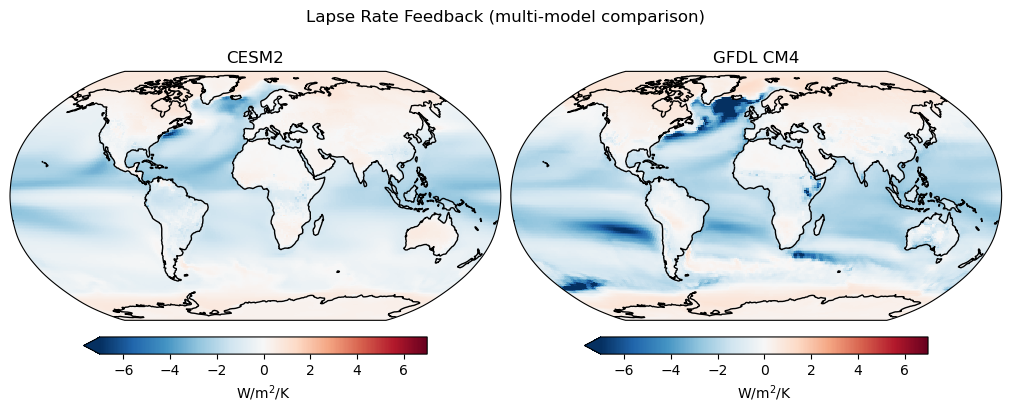

In [13]:
proj = ccrs.Robinson()

fig, axes = plt.subplots(1,2, figsize=(10,4), subplot_kw=dict(projection=proj),
                       layout="constrained")

plotargs = {"vmin": -7,
            "vmax": 7,
            "cmap": "RdBu_r",
            "cbar_kwargs": {"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$/K"}
           }

ax = axes[0]
(lr_cesm2_norm_mean).plot(ax=ax,transform=ccrs.PlateCarree(), **plotargs)
ax.set_title('CESM2')

ax = axes[1]
(lr_cm4_norm_mean).plot(ax=ax,transform=ccrs.PlateCarree(), **plotargs)
ax.set_title('GFDL CM4')

for ax in axes:
    ax.coastlines()
    
fig.suptitle('Lapse Rate Feedback (multi-model comparison)');

### Water vapor feedbacks

In [14]:
# Use ClimKern's water vapor feedback function
qlw_cesm2, qsw_cesm2 = ck.calc_q_feedbacks(
    ctrl_cesm2.hus, ctrl_cesm2.ta, ctrl_cesm2.ps,
    pert_cesm2.hus, pert_cesm2.ps, pert_trop=pert_cesm2.trop_p,
    kern="ERA5",
    method=1
)

In [15]:
qlw_cm4, qsw_cm4 = ck.calc_q_feedbacks(
    ctrl_cm4.hus, ctrl_cm4.ta, ctrl_cm4.ps,
    pert_cm4.hus, pert_cm4.ps, pert_trop=pert_cm4.trop_p,
    kern="ERA5",
    method=1
)

In [16]:
qlw_cesm2_norm_mean = (qlw_cesm2.mean(dim='time') / Δts_cesm2.mean(dim="time")).squeeze()
qlw_cm4_norm_mean = (qlw_cm4.mean(dim='time') / Δts_cm4.mean(dim="time")).squeeze()

qsw_cesm2_norm_mean = (qsw_cesm2.mean(dim='time') / Δts_cesm2.mean(dim="time")).squeeze()
qsw_cm4_norm_mean = (qsw_cm4.mean(dim='time') / Δts_cm4.mean(dim="time")).squeeze()

qtotal_cesm2_norm_mean = qlw_cesm2_norm_mean + qsw_cesm2_norm_mean
qtotal_cm4_norm_mean = qlw_cm4_norm_mean + qsw_cm4_norm_mean

Let's take a look!

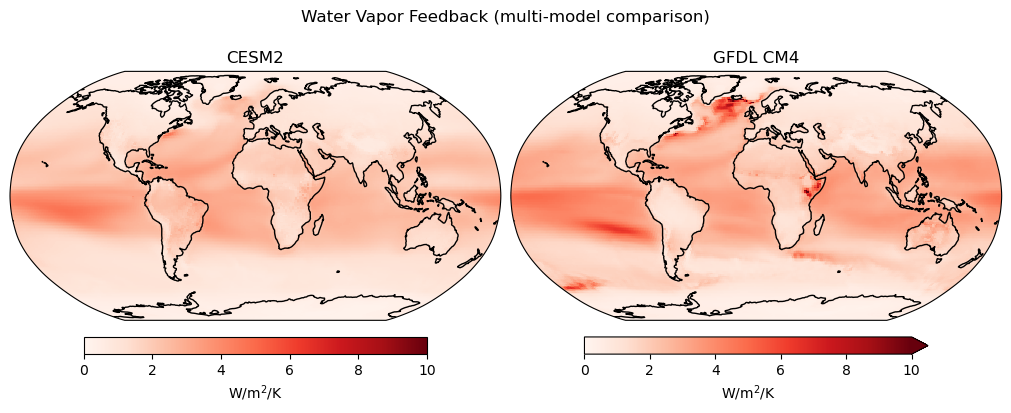

In [17]:
fig, axes = plt.subplots(1,2, figsize=(10,4), subplot_kw=dict(projection=proj),
                       layout="constrained")

plotargs = {"vmin": 0,
            "vmax": 10,
            "cmap": "Reds",
            "cbar_kwargs": {"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$/K"}
           }

ax = axes[0]
(qtotal_cesm2_norm_mean).plot(ax=ax,transform=ccrs.PlateCarree(), **plotargs)
ax.set_title('CESM2')

ax = axes[1]
(qtotal_cm4_norm_mean).plot(ax=ax,transform=ccrs.PlateCarree(), **plotargs)
ax.set_title('GFDL CM4')

for ax in axes:
    ax.coastlines()
    
fig.suptitle('Water Vapor Feedback (multi-model comparison)');

We can see that GFDL CM4 tends to have larger magnitudes of *both* the lapse rate and water vapor feedbacks compared to CESM2.

## Combined water vapor plus lapse rate feedback

In [18]:
combo_cesm2 = qtotal_cesm2_norm_mean + lr_cesm2_norm_mean
combo_cm4 = qtotal_cm4_norm_mean + lr_cm4_norm_mean

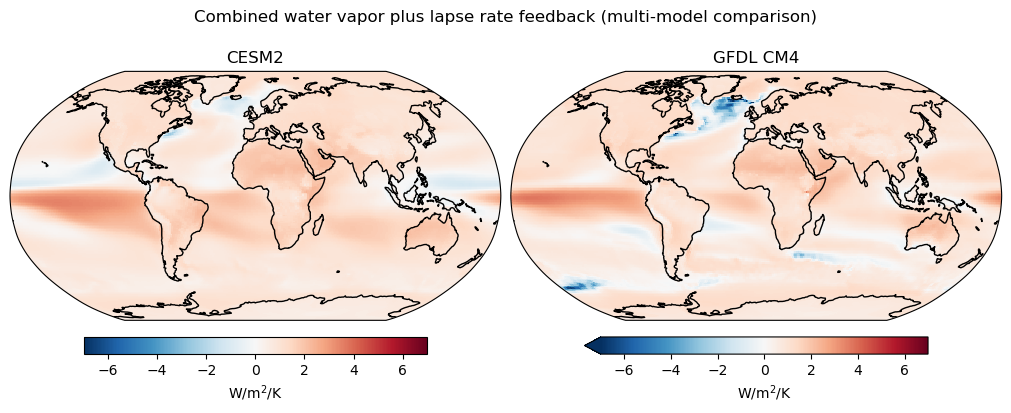

In [19]:
fig, axes = plt.subplots(1,2, figsize=(10,4), subplot_kw=dict(projection=proj),
                       layout="constrained")

plotargs = {"vmin": -7,
            "vmax": 7,
            "cmap": "RdBu_r",
            "cbar_kwargs": {"orientation": "horizontal", "shrink": 0.7,
                                      "label":"W/m$^2$/K"}
           }

ax = axes[0]
(combo_cesm2).plot(ax=ax,transform=ccrs.PlateCarree(), **plotargs)
ax.set_title('CESM2')

ax = axes[1]
(combo_cm4).plot(ax=ax,transform=ccrs.PlateCarree(), **plotargs)
ax.set_title('GFDL CM4')

for ax in axes:
    ax.coastlines()
    
fig.suptitle('Combined water vapor plus lapse rate feedback (multi-model comparison)');

Looks like the differences between the two models are more modest when we combine the two feedbacks!

## Tabulate the global mean results

We'll display the global mean values in units of W m$^{-^2}$ K$^{-1}$:

In [20]:
def global_mean(data):
    weights = np.cos(np.deg2rad(data.lat))
    return data.weighted(weights=weights).mean(dim=['lat','lon']).compute()

In [21]:
results = pd.DataFrame([
              [float(global_mean(qtotal_cesm2_norm_mean)), float(global_mean(lr_cesm2_norm_mean)), float(global_mean(combo_cesm2))],  
              [float(global_mean(qtotal_cm4_norm_mean)), float(global_mean(lr_cm4_norm_mean)), float(global_mean(combo_cm4))],
             ], 
            columns=["Water vapor ", "Lapse rate", "Combined WV+LR"],
                       index=["CESM2", "GFDL CM4"],
                      )
results

,Water vapor,Lapse rate,Combined WV+LR
CESM2,1.787328,-0.781186,1.006142
GFDL CM4,2.111078,-1.142738,0.968341


So, in conclusion, yes the difference in the combined feedbacks is smaller than the differences in the individual feedbacks!

## To do

Some interesting additions to this notebook:

- Refactor the code to loop through models rather than copy and paste the repeated operations
- Bring some more models into the comparison
- Express feedbacks in the alternate relative humidity framework discussed by {cite:t}`Held:2012a`